In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [2]:
# dataset = trn.get_dataset('3dshapes', train=None, labeled=True, device='cpu')
# len(dataset)

In [25]:
root = os.environ['FOUNDATION_SAVE_DIR'] # should be set to "trained_nets"
name = '3ds-ae-conv_0002-6337051-00_200508-232722'
name = '3ds-vae-b4-conv_0002-6337051-05_200508-232713'
name = '3ds-ae-12b1_0052-6286534-00_200429-030431'

In [26]:
results = torch.load(os.path.join(root, name, 'results.pth.tar'))
print(results.keys())
print(results['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [34]:
A = trn.get_config()
A.din = (3, 64, 64)
A.dout = A.din
model, = trn.load(name, config=A, get_data=None, update_config=True, load_last=True) # for loading only the model
print(model)

load successful
Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1_0052-6286534-00_200429-030431\checkpoint_100000.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 1 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
    [4]: 64
    [5]: 64
    [6]: 64
    [7]: 64
    [8]: 64
    [9]: 64
    [

    nonlin: elu (in parent)
    output_nonlin --> nonlin: elu (in parent)
    residual: False (by default)
      conv_kwargs (type=dict): 
  Creating branches[7] (type=norm-ada-in)
    style_dim --> din: 1
    features: 64
    pixelwise: False (by default)
    Creating net (type=mlp) (mod=normal) (in parent)
      latent_dim: 64
      min_log_std: None (by default)
      input_dim --> din: 1
      output_dim --> dout: 128
      hidden_dims --> branch_hidden (type=list): 
[0]: 64
[1]: 128
      nonlin: elu (in parent)
      output_nonlin: None (in parent)
  Creating layers[7] (type=deconv-layer)
    in_channels: 64
    out_channels: 64
    factor: 1
    size: None (by default)
    kernel_size: None (by default)
    stride: 1 (by default)
    padding: 1 (by default)
    dilation: 1 (by default)
    output_padding: 0 (by default)
    din: (64, 16, 16)
    dout: (3, 64, 64) (in parent)
    up_type: bilinear (in parent)
    norm: group (in parent)
    nonlin: elu (in parent)
    output_nonl

)


In [35]:
X = results['out']['original']
X.shape

torch.Size([128, 3, 64, 64])

In [36]:
with torch.no_grad():
    raw_Q = model.encode(X)
    if isinstance(raw_Q, distrib.Distribution):
        Q = raw_Q.mean
    else:
        Q = raw_Q
    rec = model.decode(raw_Q)
Q.shape, rec.shape

(torch.Size([128, 12]), torch.Size([128, 3, 64, 64]))

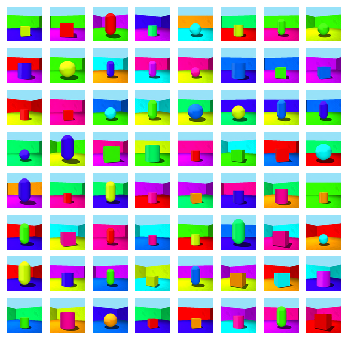

In [37]:
util.show_imgs(rec[:64])
pass

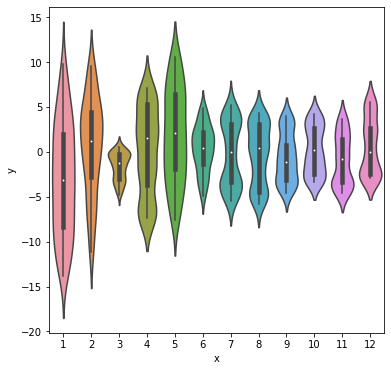

In [38]:
util.plot_distribs(Q)
pass

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x250ea99ee88>)

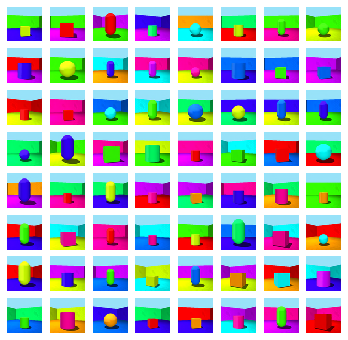

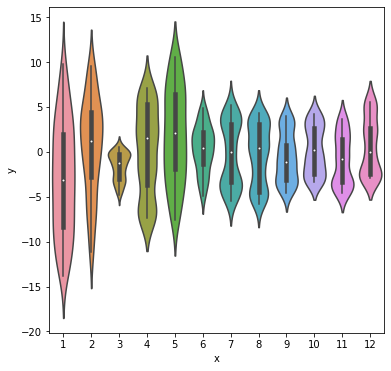

In [39]:
# comparing to saved results
save_Q = results['out']['latent']
if isinstance(save_Q, distrib.Distribution):
    save_Q = save_Q.mean
util.show_imgs(results['out']['reconstruction'][:64])
util.plot_distribs(save_Q)

In [40]:
F.mse_loss(rec, results['out']['reconstruction']), F.mse_loss(Q, save_Q)

(tensor(5.9089e-14, device='cuda:0'), tensor(8.5065e-14, device='cuda:0'))